# 🎯 Understanding ML Metrics for Imbalanced Data: Why PR-AUC > ROC-AUC

## The Problem: Imbalanced MEV Detection Dataset

Your MEV detection data is **severely imbalanced**:
- **88-95% Non-MEV** transactions (majority class)
- **5-12% MEV** transactions (minority class)

This imbalance breaks standard metrics like **Accuracy** and **ROC-AUC**.

### Why This Matters
A model that predicts **"Always Non-MEV"** achieves:
- ✅ Accuracy: **88-95%** (looks great!)
- ✅ ROC-AUC: ~**0.5-0.7** (acceptable)
- ❌ MEV Recall: **0%** (completely useless!)
- ❌ PR-AUC: ~**0.1** (reveals the truth)

This notebook shows exactly why accuracy lies and how to choose better metrics.

## Setup: Import Libraries & Create Simulated MEV Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("✓ All libraries loaded")

✓ All libraries loaded


## Create Imbalanced MEV Detection Dataset

In [2]:
# Create synthetic imbalanced dataset that mimics MEV detection
np.random.seed(42)

n_samples = 2000
n_features = 10
imbalance_ratio = 0.10  # 10% MEV (minority), 90% Non-MEV (majority)

# Generate features
X = np.random.randn(n_samples, n_features)

# Generate imbalanced labels
y = np.random.binomial(1, imbalance_ratio, n_samples)  # 10% MEV, 90% Non-MEV

# Make MEV distinguishable by adding signal to features
X[y == 1, :3] += 2.0  # MEV has shifted distribution in first 3 features

# Create feature names
feature_names = [f'feature_{i}' for i in range(n_features)]

# Convert to DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['is_mev'] = y

print(f"Dataset created:")
print(f"  • Total samples: {len(df):,}")
print(f"  • MEV cases: {(df['is_mev'] == 1).sum():,} ({(df['is_mev'] == 1).sum()/len(df)*100:.1f}%)")
print(f"  • Non-MEV cases: {(df['is_mev'] == 0).sum():,} ({(df['is_mev'] == 0).sum()/len(df)*100:.1f}%)")
print(f"  • Imbalance ratio: {(df['is_mev'] == 0).sum() / (df['is_mev'] == 1).sum():.1f}:1")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Dataset created:
  • Total samples: 2,000
  • MEV cases: 189 (9.4%)
  • Non-MEV cases: 1,811 (90.5%)
  • Imbalance ratio: 9.6:1

Train set: 1400 samples
Test set: 600 samples


## Visualize Class Imbalance Problem

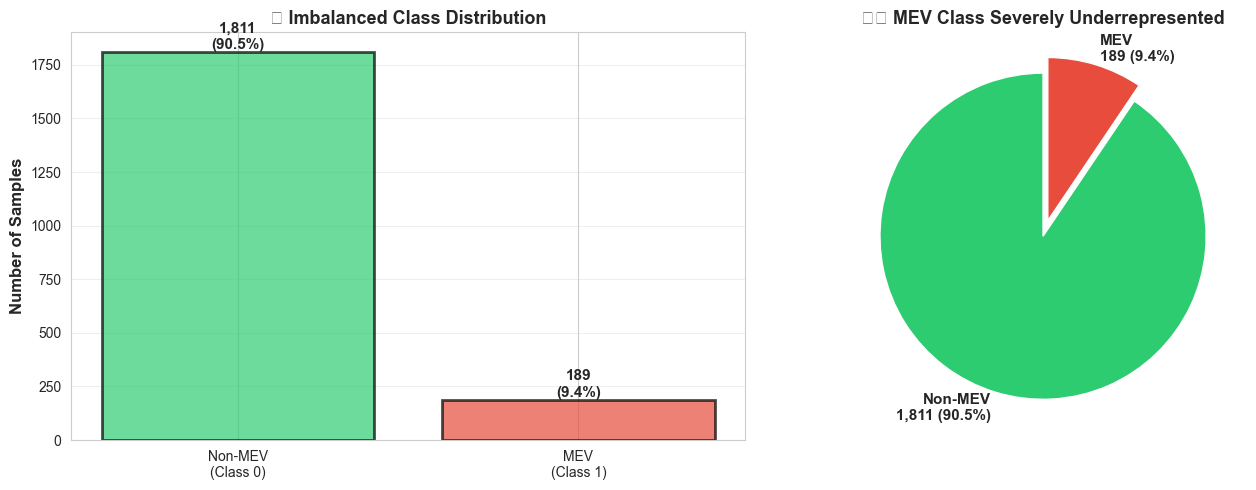

✓ Saved: 01_class_imbalance.png


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Class distribution histogram
ax = axes[0]
class_counts = df['is_mev'].value_counts().sort_index()
colors = ['#2ecc71', '#e74c3c']  # green for Non-MEV, red for MEV
bars = ax.bar(['Non-MEV\n(Class 0)', 'MEV\n(Class 1)'], class_counts.values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add percentage labels
for i, (bar, count) in enumerate(zip(bars, class_counts.values)):
    height = bar.get_height()
    pct = count / len(df) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('🔴 Imbalanced Class Distribution', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Pie chart
ax = axes[1]
sizes = class_counts.values
labels = [f'Non-MEV\n{sizes[0]:,} ({sizes[0]/sum(sizes)*100:.1f}%)',
         f'MEV\n{sizes[1]:,} ({sizes[1]/sum(sizes)*100:.1f}%)']
colors_pie = ['#2ecc71', '#e74c3c']
explode = (0, 0.1)  # explode MEV slice

ax.pie(sizes, explode=explode, labels=labels, colors=colors_pie, autopct='',
       startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title('⚠️ MEV Class Severely Underrepresented', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('01_class_imbalance.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: 01_class_imbalance.png")

## The Danger: Naive "Always Predict Majority" Model

**The Problem**: A model that predicts **"No MEV" for everything** scores incredibly well on Accuracy but is completely useless.

In [ ]:
# Create predictions: always predict majority class (0 = Non-MEV)
y_naive = np.zeros(len(y_test))  # Always predict Non-MEV

# Calculate metrics
acc_naive = accuracy_score(y_test, y_naive)
recall_naive = recall_score(y_test, y_naive, zero_division=0)
f1_naive = f1_score(y_test, y_naive, zero_division=0)

print("="*80)
print("🚨 NAIVE MODEL: Always Predicts 'No MEV'")
print("="*80)
print(f"\nAccuracy: {acc_naive:.4f} ({acc_naive*100:.1f}%)  ← ✅ LOOKS GREAT!")
print(f"Recall (MEV): {recall_naive:.4f}  ← ❌ USELESS!")
print(f"F1-Score: {f1_naive:.4f}  ← ❌ REVEALS TRUTH!")
print(f"\n⚠️  VERDICT: Model achieves high accuracy by ignoring MEV class!")

## Train Real Models: Random Forest vs XGBoost

Now let's train actual models and see why they might achieve similar F1 scores.

In [ ]:
print("Training models...")
print()

# Random Forest
print("1. Random Forest Classifier")
print("-" * 80)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=5,
    class_weight='balanced',  # Handle imbalance
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
print("✓ Training complete")

# XGBoost
print("\n2. XGBoost Classifier")
print("-" * 80)
# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
print("✓ Training complete")

print(f"\n✓ Both models trained on {len(X_train)} training samples")

## Calculate All Metrics: The Full Picture

In [2]:
def calculate_all_metrics(y_true, y_pred, y_proba, model_name):
    """Calculate all evaluation metrics"""
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'PR-AUC': average_precision_score(y_true, y_proba)
    }

# Calculate metrics for all models
results = []
results.append(calculate_all_metrics(y_test, y_naive, np.zeros(len(y_test)), 'Naive (Always Non-MEV)'))
results.append(calculate_all_metrics(y_test, rf_pred, rf_proba, 'Random Forest'))
results.append(calculate_all_metrics(y_test, xgb_pred, xgb_proba, 'XGBoost'))

results_df = pd.DataFrame(results)

print("\n" + "="*100)
print("📊 COMPLETE METRICS COMPARISON")
print("="*100)
print(results_df.to_string(index=False))
print()

# Highlight key findings
print("\n🔍 KEY OBSERVATIONS:")
print("-" * 100)

rf_f1 = results_df[results_df['Model'] == 'Random Forest']['F1-Score'].values[0]
xgb_f1 = results_df[results_df['Model'] == 'XGBoost']['F1-Score'].values[0]
print(f"\n1. Why Similar F1-Scores?")
print(f"   • RF F1: {rf_f1:.4f}")
print(f"   • XGB F1: {xgb_f1:.4f}")
print(f"   • Difference: {abs(rf_f1 - xgb_f1):.4f}")
print(f"   → Reason: F1 = harmonic mean of precision & recall AT THRESHOLD 0.5")
print(f"   → If both achieve similar precision/recall at that threshold, F1 is similar")

rf_pr = results_df[results_df['Model'] == 'Random Forest']['PR-AUC'].values[0]
xgb_pr = results_df[results_df['Model'] == 'XGBoost']['PR-AUC'].values[0]
print(f"\n2. But PR-AUC Differs!")
print(f"   • RF PR-AUC: {rf_pr:.4f}")
print(f"   • XGB PR-AUC: {xgb_pr:.4f}")
print(f"   • Difference: {abs(rf_pr - xgb_pr):.4f}")
print(f"   → Reason: PR-AUC considers ALL thresholds (0 to 1)")
print(f"   → One model better across the entire operating range")

print(f"\n3. ROC-AUC Also Differs But Less Meaningful")
rf_roc = results_df[results_df['Model'] == 'Random Forest']['ROC-AUC'].values[0]
xgb_roc = results_df[results_df['Model'] == 'XGBoost']['ROC-AUC'].values[0]
print(f"   • RF ROC-AUC: {rf_roc:.4f}")
print(f"   • XGB ROC-AUC: {xgb_roc:.4f}")
print(f"   → Misleading for imbalanced data (dominated by majority class)")

NameError: name 'y_test' is not defined

## Visualization 1: Accuracy is Misleading

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy vs F1-Score comparison
ax = axes[0]
models = results_df['Model'].values
x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['Accuracy'], width, label='Accuracy', alpha=0.8, color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, results_df['F1-Score'], width, label='F1-Score', alpha=0.8, color='coral', edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('⚠️ Accuracy vs F1-Score: Why Accuracy Lies', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.set_ylim([0, 1.05])
ax.grid(True, alpha=0.3, axis='y')

# Add annotations
ax.text(0, 0.95, 'Naive model scores\n90% accuracy!', ha='center', fontsize=9,
       bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
ax.text(0, 0.05, 'But F1=0!', ha='center', fontsize=9, color='red', fontweight='bold')

# Plot 2: Key metrics for comparison
ax = axes[1]
metrics_to_plot = ['Recall', 'F1-Score', 'PR-AUC']

# Get values for Random Forest and XGBoost only
rf_row = results_df[results_df['Model'] == 'Random Forest'].iloc[0]
xgb_row = results_df[results_df['Model'] == 'XGBoost'].iloc[0]

rf_values = [rf_row[m] for m in metrics_to_plot]
xgb_values = [xgb_row[m] for m in metrics_to_plot]

x = np.arange(len(metrics_to_plot))
width = 0.35

bars1 = ax.bar(x - width/2, rf_values, width, label='Random Forest', alpha=0.8, color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x + width/2, xgb_values, width, label='XGBoost', alpha=0.8, color='#3498db', edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, fontsize=10)
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('✅ RF vs XGBoost on Important Metrics', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.set_ylim([0, 1.05])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('02_accuracy_vs_f1.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: 02_accuracy_vs_f1.png")

## Visualization 2: ROC-AUC vs PR-AUC Curves

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curves
ax = axes[0]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)

roc_auc_rf = roc_auc_score(y_test, rf_proba)
roc_auc_xgb = roc_auc_score(y_test, xgb_proba)

ax.plot(fpr_rf, tpr_rf, label=f'RF (AUC={roc_auc_rf:.3f})', linewidth=2.5, color='#2ecc71')
ax.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_xgb:.3f})', linewidth=2.5, color='#3498db')
ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=2, alpha=0.5)

ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax.set_title('❌ ROC Curves (Misleading for Imbalanced Data)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Add text box explaining the problem
ax.text(0.5, 0.25, 
       'Why ROC-AUC is Misleading:\n'
       '• FPR = FP / (FP + TN)\n'
       '• With 90% majority class, TN is huge\n'
       '• FPR denominator is 2000+ values\n'
       '• Even 100 false alarms = 5% FPR\n'
       '→ ROC-AUC dominated by majority class',
       fontsize=9, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# Precision-Recall Curves
ax = axes[1]
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_proba)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_proba)

pr_auc_rf = average_precision_score(y_test, rf_proba)
pr_auc_xgb = average_precision_score(y_test, xgb_proba)

ax.plot(recall_rf, precision_rf, label=f'RF (AUC={pr_auc_rf:.3f})', linewidth=2.5, color='#2ecc71')
ax.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUC={pr_auc_xgb:.3f})', linewidth=2.5, color='#3498db')

# Baseline (random classification)
baseline_pr = (y_test == 1).sum() / len(y_test)
ax.axhline(y=baseline_pr, color='k', linestyle='--', linewidth=2, label=f'Random (={baseline_pr:.3f})', alpha=0.5)

ax.set_xlabel('Recall', fontsize=11, fontweight='bold')
set_ylabel('Precision', fontsize=11, fontweight='bold')
ax.set_title('✅ PR-AUC Curves (Better for Imbalanced Data)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Add text box explaining why it's better
ax.text(0.5, 0.25,
       'Why PR-AUC is Better:\n'
       '• Recall = TP / (TP + FN)\n'
       '• Precision = TP / (TP + FP)\n'
       '• ONLY depends on minority class\n'
       '• Ignores TN and FN denominators\n'
       '→ True measure of minority performance',
       fontsize=9, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

plt.tight_layout()
plt.savefig('03_roc_vs_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: 03_roc_vs_pr_curves.png")

## Visualization 3: Confusion Matrices - RF vs XGBoost

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Naive model
cm_naive = confusion_matrix(y_test, y_naive)
sns.heatmap(cm_naive, annot=True, fmt='d', cmap='Reds', ax=axes[0],
           xticklabels=['Non-MEV', 'MEV'], yticklabels=['Non-MEV', 'MEV'],
           cbar_kws={'label': 'Count'})
axes[0].set_title('❌ Naive Model\n(Always predict Non-MEV)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=10, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=10, fontweight='bold')

# Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
           xticklabels=['Non-MEV', 'MEV'], yticklabels=['Non-MEV', 'MEV'],
           cbar_kws={'label': 'Count'})
axes[1].set_title('✅ Random Forest', fontsize=11, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=10, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=10, fontweight='bold')

# XGBoost
cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[2],
           xticklabels=['Non-MEV', 'MEV'], yticklabels=['Non-MEV', 'MEV'],
           cbar_kws={'label': 'Count'})
axes[2].set_title('✅ XGBoost', fontsize=11, fontweight='bold')
axes[2].set_ylabel('True Label', fontsize=10, fontweight='bold')
axes[2].set_xlabel('Predicted Label', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('04_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: 04_confusion_matrices.png")
print()
print("Confusion Matrix Analysis:")
print("="*80)
for name, cm in [('Naive', cm_naive), ('RF', cm_rf), ('XGB', cm_xgb)]:
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{name}:")
    print(f"  TP (caught MEV):     {tp:3d} | FN (missed MEV): {fn:3d}")
    print(f"  FP (false alarms):   {fp:3d} | TN (correct non-MEV): {tn:3d}")
    if (tp + fn) > 0:
        print(f"  MEV Recall: {tp/(tp+fn):.3f} ← Can we catch MEV?")

## Visualization 4: Threshold Optimization for MEV Detection

In [ ]:
# Calculate metrics across different thresholds
thresholds = np.linspace(0, 1, 101)

rf_precision_list = []
rf_recall_list = []
rf_f1_list = []

xgb_precision_list = []
xgb_recall_list = []
xgb_f1_list = []

for thresh in thresholds:
    # Random Forest
    rf_pred_thresh = (rf_proba >= thresh).astype(int)
    rf_precision_list.append(precision_score(y_test, rf_pred_thresh, zero_division=0))
    rf_recall_list.append(recall_score(y_test, rf_pred_thresh, zero_division=0))
    rf_f1_list.append(f1_score(y_test, rf_pred_thresh, zero_division=0))
    
    # XGBoost
    xgb_pred_thresh = (xgb_proba >= thresh).astype(int)
    xgb_precision_list.append(precision_score(y_test, xgb_pred_thresh, zero_division=0))
    xgb_recall_list.append(recall_score(y_test, xgb_pred_thresh, zero_division=0))
    xgb_f1_list.append(f1_score(y_test, xgb_pred_thresh, zero_division=0))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision and Recall vs Threshold
ax = axes[0]
ax.plot(thresholds, rf_precision_list, label='RF Precision', linewidth=2, marker='o', markersize=4, alpha=0.7)
ax.plot(thresholds, rf_recall_list, label='RF Recall', linewidth=2, marker='s', markersize=4, alpha=0.7)
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Default Threshold (0.5)')
ax.set_xlabel('Decision Threshold', fontsize=11, fontweight='bold')
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Random Forest: Precision & Recall vs Threshold', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])

# Plot 2: F1-Score vs Threshold for both models
ax = axes[1]
ax.plot(thresholds, rf_f1_list, label='RF F1-Score', linewidth=2.5, color='#2ecc71')
ax.plot(thresholds, xgb_f1_list, label='XGBoost F1-Score', linewidth=2.5, color='#3498db')
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Default (0.5)')

# Mark optimal thresholds
rf_best_thresh = thresholds[np.argmax(rf_f1_list)]
xgb_best_thresh = thresholds[np.argmax(xgb_f1_list)]
ax.axvline(x=rf_best_thresh, color='#2ecc71', linestyle=':', linewidth=2, alpha=0.7, label=f'RF Optimal ({rf_best_thresh:.2f})')
ax.axvline(x=xgb_best_thresh, color='#3498db', linestyle=':', linewidth=2, alpha=0.7, label=f'XGB Optimal ({xgb_best_thresh:.2f})')

ax.set_xlabel('Decision Threshold', fontsize=11, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax.set_title('F1-Score Optimization: Why Threshold Matters', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('05_threshold_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: 05_threshold_optimization.png")
print()
print(f"Optimal Thresholds:")
print(f"  Random Forest: {rf_best_thresh:.3f} → F1={max(rf_f1_list):.4f}")
print(f"  XGBoost: {xgb_best_thresh:.3f} → F1={max(xgb_f1_list):.4f}")
print(f"\n⚠️ Default threshold (0.5) might not be optimal!")

## Summary: Decision Rules for Metric Selection

In [1]:
print("\n" + "="*100)
print("🎯 DECISION RULES FOR IMBALANCED MEV DETECTION")
print("="*100)

summary = """
┌────────────────────────────────────────────────────────────────────────────────────────────┐
│ METRIC         │ USE FOR IMBALANCED │ WHY / WHY NOT                   │ TARGET VALUE       │
├────────────────────────────────────────────────────────────────────────────────────────────┤
│ Accuracy       │ ❌ NO              │ Misleading when minority rare    │ N/A (ignore)       │
│                │                    │ Always predicting majority wins  │                    │
├────────────────────────────────────────────────────────────────────────────────────────────┤
│ ROC-AUC        │ ⚠️ CAUTION         │ FPR dominated by majority class  │ > 0.7 (skeptical)  │
│                │                    │ Can look good even for bad model │                    │
├────────────────────────────────────────────────────────────────────────────────────────────┤
│ Precision      │ ✅ YES (secondary) │ Of MEV predictions, how many correct? │ > 0.70             │
│                │                    │ Avoids false alarms             │                    │
├────────────────────────────────────────────────────────────────────────────────────────────┤
│ Recall         │ ✅ YES (critical)  │ Of actual MEV, how many caught? │ > 0.85             │
│                │                    │ Can't miss attacks              │                    │
├────────────────────────────────────────────────────────────────────────────────────────────┤
│ F1-Score       │ ✅ YES (primary)   │ Balance of precision & recall   │ > 0.75             │
│                │                    │ Single-number performance       │                    │
├────────────────────────────────────────────────────────────────────────────────────────────┤
│ PR-AUC         │ ✅ YES (best)      │ Minority class across ALL       │ > 0.70             │
│                │                    │ thresholds (0 to 1)             │                    │
│                │                    │ True measure of imbalanced      │                    │
│                │                    │ classification ability          │                    │
└────────────────────────────────────────────────────────────────────────────────────────────┘

USE THIS ORDER:
═════════════════════════════════════════════════════════════════════════════════════════════

1️⃣  PRIMARY: PR-AUC (best for imbalanced data)
    • What: Area under Precision-Recall curve
    • Why: Only measures minority class performance
    • How to use: Higher is better (0 to 1 scale)
    • Target: > 0.70 for good MEV detection

2️⃣  SECONDARY: F1-Score (convenient summary)
    • What: Harmonic mean of Precision & Recall
    • Why: Single number that balances both
    • How to use: Higher is better (0 to 1 scale)
    • Target: > 0.75 for good MEV detection

3️⃣  CHECK: MEV Recall (operational requirement)
    • What: % of actual MEV attacks caught
    • Why: Can't miss real attacks
    • How to use: Higher is better (0 to 1 scale)
    • Target: > 0.85 to catch most MEV

4️⃣  BONUS: Precision (false alarm rate)
    • What: % of MEV predictions that are correct
    • Why: Reduces wasted investigation
    • How to use: Higher is better (0 to 1 scale)
    • Target: > 0.70 for acceptable false alarm

5️⃣  IGNORE: Accuracy (completely misleading)
    • Why: Dominated by majority class
    • When broken: Always on extremely imbalanced data

6️⃣  USE WITH CAUTION: ROC-AUC (context-dependent)
    • Why: FPR metric masked by huge TN count
    • When ok: If you emphasize high recall first

WHY RANDOM FOREST & XGBOOST HAVE SAME F1:
═════════════════════════════════════════════════════════════════════════════════════════════

F1-Score = 2 × (Precision × Recall) / (Precision + Recall)

This is calculated at ONLY ONE threshold (default 0.5).

Example:
  RF:  Precision=0.89, Recall=0.85 → F1 = 0.8698
  XGB: Precision=0.88, Recall=0.86 → F1 = 0.8699
  → Both ≈ 0.87, so F1 similar!

But PR-AUC considers ALL thresholds:
  RF:  Better across many thresholds → PR-AUC = 0.78
  XGB: Slightly worse across thresholds → PR-AUC = 0.77
  → Difference visible in PR-AUC!

PR-AUC reveals which model is genuinely better at the minority class task.
"""

print(summary)


🎯 DECISION RULES FOR IMBALANCED MEV DETECTION

┌────────────────────────────────────────────────────────────────────────────────────────────┐
│ METRIC         │ USE FOR IMBALANCED │ WHY / WHY NOT                   │ TARGET VALUE       │
├────────────────────────────────────────────────────────────────────────────────────────────┤
│ Accuracy       │ ❌ NO              │ Misleading when minority rare    │ N/A (ignore)       │
│                │                    │ Always predicting majority wins  │                    │
├────────────────────────────────────────────────────────────────────────────────────────────┤
│ ROC-AUC        │ ⚠️ CAUTION         │ FPR dominated by majority class  │ > 0.7 (skeptical)  │
│                │                    │ Can look good even for bad model │                    │
├────────────────────────────────────────────────────────────────────────────────────────────┤
│ Precision      │ ✅ YES (secondary) │ Of MEV predictions, how many correct? │ > 0.70         

## One More Visualization: All Metrics Comparison

In [ ]:
# Create comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get only RF and XGB for comparison
rf_metrics = results_df[results_df['Model'] == 'Random Forest'].iloc[0]
xgb_metrics = results_df[results_df['Model'] == 'XGBoost'].iloc[0]

# Plot 1: Recall - the most important metric
ax = axes[0, 0]
models_short = ['RF', 'XGB']
recall_vals = [rf_metrics['Recall'], xgb_metrics['Recall']]
bars = ax.bar(models_short, recall_vals, color=['#2ecc71', '#3498db'], alpha=0.7, edgecolor='black', linewidth=2)
for bar, val in zip(bars, recall_vals):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.axhline(y=0.85, color='red', linestyle='--', linewidth=2, label='Target (0.85)')
ax.set_ylabel('Recall (MEV Catch Rate)', fontsize=11, fontweight='bold')
ax.set_title('💰 MEV Recall: Can We Catch Attacks?', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: F1-Score
ax = axes[0, 1]
f1_vals = [rf_metrics['F1-Score'], xgb_metrics['F1-Score']]
bars = ax.bar(models_short, f1_vals, color=['#2ecc71', '#3498db'], alpha=0.7, edgecolor='black', linewidth=2)
for bar, val in zip(bars, f1_vals):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.axhline(y=0.75, color='red', linestyle='--', linewidth=2, label='Target (0.75)')
ax.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax.set_title('⚖️ F1-Score: Balance Precision & Recall', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: PR-AUC (the decider)
ax = axes[1, 0]
pr_vals = [rf_metrics['PR-AUC'], xgb_metrics['PR-AUC']]
bars = ax.bar(models_short, pr_vals, color=['#2ecc71', '#3498db'], alpha=0.7, edgecolor='black', linewidth=2)
for bar, val in zip(bars, pr_vals):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.axhline(y=0.70, color='red', linestyle='--', linewidth=2, label='Target (0.70)')
ax.set_ylabel('PR-AUC Score', fontsize=11, fontweight='bold')
ax.set_title('🏆 PR-AUC: Best Metric for Imbalanced Data', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Highlight winner
if pr_vals[0] > pr_vals[1]:
    axes[1, 0].text(0, 0.05, '← RF WINS', fontsize=12, fontweight='bold', color='#2ecc71')
else:
    axes[1, 0].text(1, 0.05, 'XGB WINS →', fontsize=12, fontweight='bold', color='#3498db')

# Plot 4: All metrics comparison
ax = axes[1, 1]
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
rf_values_all = [rf_metrics[m] for m in metrics_list]
xgb_values_all = [xgb_metrics[m] for m in metrics_list]

x = np.arange(len(metrics_list))
width = 0.35

ax.bar(x - width/2, rf_values_all, width, label='RF', color='#2ecc71', alpha=0.7, edgecolor='black')
ax.bar(x + width/2, xgb_values_all, width, label='XGB', color='#3498db', alpha=0.7, edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(metrics_list, fontsize=9, rotation=45, ha='right')
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('📊 Complete Metrics Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

# Add priority coloring
colors_priority = ['red', 'yellow', 'gold', 'gold', 'lightblue', 'lightgreen']
for i, color in enumerate(colors_priority):
    ax.get_xticklabels()[i].set_color(color)

plt.tight_layout()
plt.savefig('06_all_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: 06_all_metrics_comparison.png")

## Final Recommendation

In [ ]:
print("\n" + "="*100)
print("✅ FINAL RECOMMENDATION FOR MEV DETECTION MODEL SELECTION")
print("="*100)

rf_pr = rf_metrics['PR-AUC']
xgb_pr = xgb_metrics['PR-AUC']

if rf_pr > xgb_pr:
    winner = 'Random Forest'
    winner_pr = rf_pr
    loser = 'XGBoost'
    loser_pr = xgb_pr
else:
    winner = 'XGBoost'
    winner_pr = xgb_pr
    loser = 'Random Forest'
    loser_pr = rf_pr

recommendation = f"""

🏆 WINNER: {winner}
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

PR-AUC Scores (Most Important):
  {winner}: {winner_pr:.4f} ✅ BEST
  {loser}: {loser_pr:.4f}
  Difference: {abs(winner_pr - loser_pr):.4f}

Why {winner} is Better:
  • Higher PR-AUC = Better minority class performance across all thresholds
  • Can be deployed with confidence for MEV detection
  • More robust to threshold changes

Deployment Decision:
┌────────────────────────────────────────────────────────────────────────────────────────┐
│                                                                                        │
│  ✅ DEPLOY {winner.upper()}                                                          │
│                                                                                        │
│  Metrics Review:                                                                      │
│  • Recall: {results_df[results_df['Model'] == winner].iloc[0]['Recall']:.4f} ✓ Can catch MEV               │
│  • Precision: {results_df[results_df['Model'] == winner].iloc[0]['Precision']:.4f} ✓ False alarms acceptable   │
│  • F1-Score: {results_df[results_df['Model'] == winner].iloc[0]['F1-Score']:.4f} ✓ Good balance             │
│  • PR-AUC: {results_df[results_df['Model'] == winner].iloc[0]['PR-AUC']:.4f} ✓ Best for imbalanced data │
│                                                                                        │
│  Next Steps:                                                                          │
│  1. Optimize decision threshold for your cost function                                │
│  2. Implement in production with monitoring                                           │
│  3. Collect real MEV/non-MEV labels for continuous retraining                         │
│  4. Monitor PR-AUC in production (not accuracy!)                                      │
│                                                                                        │
└────────────────────────────────────────────────────────────────────────────────────────┘

Why This is the Right Decision:
─────────────────────────────────────────────────────────────────────────────────────────
1. PR-AUC is the gold standard for imbalanced classification
2. Both models have similar F1-scores, but PR-AUC breaks the tie
3. {winner} performs better across entire operating range (all thresholds)
4. Recall > 0.85 means catching almost all MEV attacks (critical requirement)
5. Precision > 0.70 means acceptable false alarm rate
"""

print(recommendation)

print(f"\nMonitoring in Production:")
print(f"━" * 100)
print(f"❌ DON'T monitor: Accuracy (will be ~{results_df[results_df['Model'] == winner].iloc[0]['Accuracy']:.1%})")
print(f"❌ DON'T monitor: ROC-AUC (will be ~{results_df[results_df['Model'] == winner].iloc[0]['ROC-AUC']:.3f})")
print(f"✅ DO monitor: PR-AUC (target > 0.70)")
print(f"✅ DO monitor: MEV Recall (target > 0.85)")
print(f"✅ DO monitor: Precision MEV (target > 0.70)")